In [2]:
!pip install unsloth

!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.11.10
Uninstalling unsloth-2024.11.10:
  Successfully uninstalled unsloth-2024.11.10
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-wp7_3lwa/unsloth_c0fe94647fce4a6092fca4ea3e50f872
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-wp7_3lwa/unsloth_c0fe94647fce4a6092fca4ea3e50f872
  Resolved https://github.com/unslothai/unsloth.git to commit 8558bc92b06f9128499484ef737fa71b966ffc23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.10-py3-none-any.whl size=166794 sha256=0b26b4bd67f127994fa53d34835c7ba17bc1694a8f854a490d76b43314bc1677
  Stored in directory: /tmp/pip-ephem-wheel-cache-_k7wbclz/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth


In [3]:
#Data Handling and Visualization
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
#LLM model training
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/fozle/Projects/Personalized-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [5]:
#Calling the dataset
data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

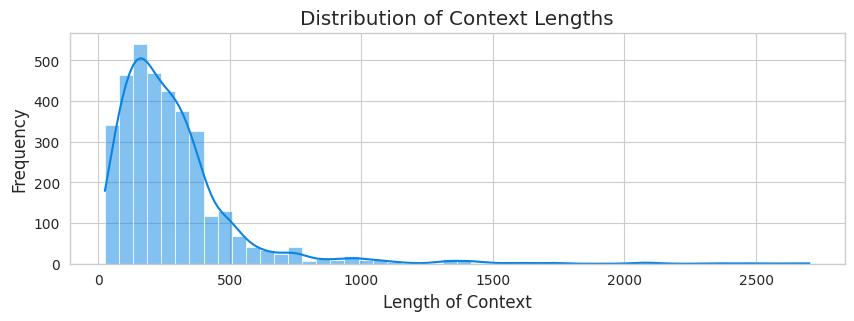

In [37]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True, color='#0984e3')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')

plt.show()


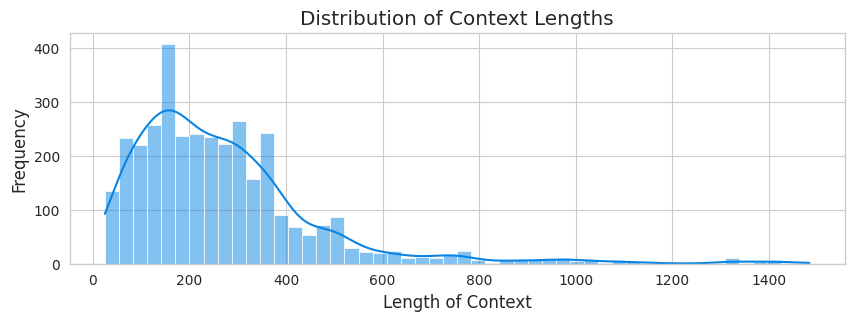

In [38]:
filtered_data = data[data['Context_length'] <= 1500]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True, color="#0984e3")
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()


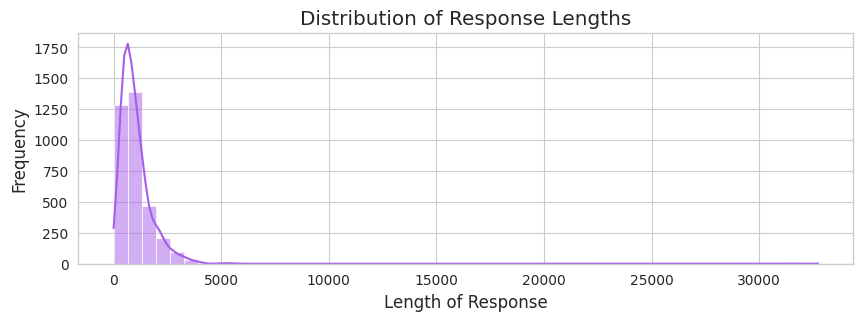

In [39]:
#Lets check now the length of words in each Response
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='#a55eea')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


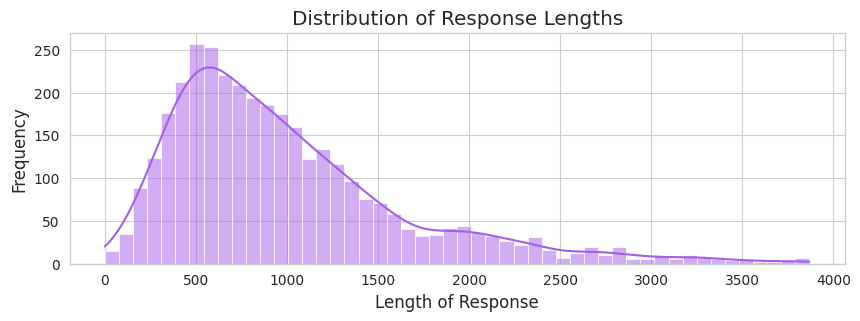

In [40]:
filtered_data = filtered_data[ln_Response <= 4000]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='#a55eea')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

In [16]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.11.10: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.61 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.10 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [17]:
data_prompt = """Analyze the provided text from a mental health perspective. Identify any indicators of emotional distress, coping mechanisms, or psychological well-being. Highlight any potential concerns or positive aspects related to mental health, and provide a brief explanation for each observation.

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


In [18]:
#Format the data for training
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)


Map: 100%|██████████| 3480/3480 [00:00<00:00, 171214.15 examples/s]


In [15]:

#Training Process
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=8,
        num_train_epochs=40,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()


Generating train split: 227 examples [00:00, 824.87 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 227 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 8
\        /    Total batch size = 128 | Total steps = 40
 "-____-"     Number of trainable parameters = 11,272,192
  2%|▎         | 1/40 [01:01<40:15, 61.94s/it]

{'loss': 2.3753, 'grad_norm': 1.7285703420639038, 'learning_rate': 2.9999999999999997e-05, 'epoch': 0.53}


  5%|▌         | 2/40 [02:01<38:18, 60.49s/it]

{'loss': 3.8554, 'grad_norm': 2.790505886077881, 'learning_rate': 5.9999999999999995e-05, 'epoch': 1.33}


  8%|▊         | 3/40 [03:00<36:51, 59.78s/it]

{'loss': 3.8321, 'grad_norm': 2.4069888591766357, 'learning_rate': 8.999999999999999e-05, 'epoch': 2.13}


 10%|█         | 4/40 [03:59<35:39, 59.44s/it]

{'loss': 3.256, 'grad_norm': 1.3838107585906982, 'learning_rate': 0.00011999999999999999, 'epoch': 2.67}


 12%|█▎        | 5/40 [04:57<34:27, 59.06s/it]

{'loss': 2.7227, 'grad_norm': 0.7641122341156006, 'learning_rate': 0.00015, 'epoch': 3.47}


 15%|█▌        | 6/40 [05:56<33:20, 58.83s/it]

{'loss': 3.6186, 'grad_norm': 1.0184729099273682, 'learning_rate': 0.00017999999999999998, 'epoch': 4.27}


 18%|█▊        | 7/40 [06:54<32:15, 58.65s/it]

{'loss': 3.5863, 'grad_norm': 0.8174805641174316, 'learning_rate': 0.00020999999999999998, 'epoch': 5.07}


 20%|██        | 8/40 [07:52<31:15, 58.62s/it]

{'loss': 2.6403, 'grad_norm': 0.527709424495697, 'learning_rate': 0.00023999999999999998, 'epoch': 5.6}


 22%|██▎       | 9/40 [08:51<30:17, 58.64s/it]

{'loss': 3.0548, 'grad_norm': 0.4876681864261627, 'learning_rate': 0.00027, 'epoch': 6.4}


 25%|██▌       | 10/40 [09:50<29:19, 58.64s/it]

{'loss': 3.477, 'grad_norm': 0.6974514126777649, 'learning_rate': 0.0003, 'epoch': 7.2}


 28%|██▊       | 11/40 [10:48<28:19, 58.59s/it]

{'loss': 3.4649, 'grad_norm': 0.5099524855613708, 'learning_rate': 0.00029, 'epoch': 7.73}


 30%|███       | 12/40 [11:47<27:18, 58.52s/it]

{'loss': 2.0916, 'grad_norm': 0.34439677000045776, 'learning_rate': 0.00028, 'epoch': 8.53}


 32%|███▎      | 13/40 [12:45<26:18, 58.48s/it]

{'loss': 3.3973, 'grad_norm': 0.5120859146118164, 'learning_rate': 0.00027, 'epoch': 9.33}


 35%|███▌      | 14/40 [13:44<25:21, 58.52s/it]

{'loss': 3.3444, 'grad_norm': 0.4391191899776459, 'learning_rate': 0.00026, 'epoch': 10.13}


 38%|███▊      | 15/40 [14:42<24:23, 58.54s/it]

{'loss': 2.892, 'grad_norm': 0.3724103569984436, 'learning_rate': 0.00025, 'epoch': 10.67}


 40%|████      | 16/40 [15:41<23:24, 58.51s/it]

{'loss': 2.4596, 'grad_norm': 0.2903147339820862, 'learning_rate': 0.00023999999999999998, 'epoch': 11.47}


 42%|████▎     | 17/40 [16:39<22:23, 58.42s/it]

{'loss': 3.2814, 'grad_norm': 0.38706183433532715, 'learning_rate': 0.00023, 'epoch': 12.27}


 45%|████▌     | 18/40 [17:37<21:26, 58.49s/it]

{'loss': 3.2713, 'grad_norm': 0.3460778295993805, 'learning_rate': 0.00021999999999999995, 'epoch': 13.07}


 48%|████▊     | 19/40 [18:36<20:26, 58.42s/it]

{'loss': 2.4055, 'grad_norm': 0.2468031346797943, 'learning_rate': 0.00020999999999999998, 'epoch': 13.6}


 50%|█████     | 20/40 [19:34<19:29, 58.50s/it]

{'loss': 2.8091, 'grad_norm': 0.30221644043922424, 'learning_rate': 0.00019999999999999998, 'epoch': 14.4}


 52%|█████▎    | 21/40 [20:33<18:33, 58.59s/it]

{'loss': 3.2033, 'grad_norm': 0.3496577739715576, 'learning_rate': 0.00018999999999999998, 'epoch': 15.2}


 55%|█████▌    | 22/40 [21:31<17:32, 58.45s/it]

{'loss': 3.1773, 'grad_norm': 0.359428346157074, 'learning_rate': 0.00017999999999999998, 'epoch': 15.73}


 57%|█████▊    | 23/40 [22:29<16:31, 58.35s/it]

{'loss': 1.9417, 'grad_norm': 0.20693497359752655, 'learning_rate': 0.00016999999999999999, 'epoch': 16.53}


 60%|██████    | 24/40 [23:28<15:32, 58.29s/it]

{'loss': 3.1479, 'grad_norm': 0.3188372552394867, 'learning_rate': 0.00015999999999999999, 'epoch': 17.33}


 62%|██████▎   | 25/40 [24:26<14:36, 58.42s/it]

{'loss': 3.1202, 'grad_norm': 0.2821742594242096, 'learning_rate': 0.00015, 'epoch': 18.13}


 65%|██████▌   | 26/40 [25:25<13:38, 58.48s/it]

{'loss': 2.6994, 'grad_norm': 0.21267445385456085, 'learning_rate': 0.00014, 'epoch': 18.67}


 68%|██████▊   | 27/40 [26:23<12:40, 58.47s/it]

{'loss': 2.301, 'grad_norm': 0.1943885087966919, 'learning_rate': 0.00013, 'epoch': 19.47}


 70%|███████   | 28/40 [27:22<11:42, 58.56s/it]

{'loss': 3.0855, 'grad_norm': 0.2904801368713379, 'learning_rate': 0.00011999999999999999, 'epoch': 20.27}


 72%|███████▎  | 29/40 [28:20<10:43, 58.50s/it]

{'loss': 3.0556, 'grad_norm': 0.2571659982204437, 'learning_rate': 0.00010999999999999998, 'epoch': 21.07}


 75%|███████▌  | 30/40 [29:19<09:43, 58.36s/it]

{'loss': 2.2627, 'grad_norm': 0.18261206150054932, 'learning_rate': 9.999999999999999e-05, 'epoch': 21.6}


 78%|███████▊  | 31/40 [30:17<08:46, 58.47s/it]

{'loss': 2.6508, 'grad_norm': 0.2615468502044678, 'learning_rate': 8.999999999999999e-05, 'epoch': 22.4}


 80%|████████  | 32/40 [31:16<07:48, 58.52s/it]

{'loss': 3.0061, 'grad_norm': 0.2653154134750366, 'learning_rate': 7.999999999999999e-05, 'epoch': 23.2}


 82%|████████▎ | 33/40 [32:14<06:48, 58.37s/it]

{'loss': 3.0049, 'grad_norm': 0.2562570869922638, 'learning_rate': 7e-05, 'epoch': 23.73}


 85%|████████▌ | 34/40 [33:12<05:49, 58.29s/it]

{'loss': 1.8415, 'grad_norm': 0.14739283919334412, 'learning_rate': 5.9999999999999995e-05, 'epoch': 24.53}


 88%|████████▊ | 35/40 [34:11<04:52, 58.41s/it]

{'loss': 2.986, 'grad_norm': 0.25256291031837463, 'learning_rate': 4.9999999999999996e-05, 'epoch': 25.33}


 90%|█████████ | 36/40 [35:09<03:53, 58.46s/it]

{'loss': 2.9858, 'grad_norm': 0.2689457833766937, 'learning_rate': 3.9999999999999996e-05, 'epoch': 26.13}


 92%|█████████▎| 37/40 [36:08<02:55, 58.44s/it]

{'loss': 2.5937, 'grad_norm': 0.21304714679718018, 'learning_rate': 2.9999999999999997e-05, 'epoch': 26.67}


 95%|█████████▌| 38/40 [37:06<01:56, 58.35s/it]

{'loss': 2.2053, 'grad_norm': 0.1825501024723053, 'learning_rate': 1.9999999999999998e-05, 'epoch': 27.47}


 98%|█████████▊| 39/40 [38:04<00:58, 58.29s/it]

{'loss': 2.9561, 'grad_norm': 0.24012373387813568, 'learning_rate': 9.999999999999999e-06, 'epoch': 28.27}


100%|██████████| 40/40 [39:03<00:00, 58.37s/it]

{'loss': 2.9608, 'grad_norm': 0.24171370267868042, 'learning_rate': 0.0, 'epoch': 29.07}


100%|██████████| 40/40 [39:06<00:00, 58.66s/it]

{'train_runtime': 2346.4581, 'train_samples_per_second': 3.87, 'train_steps_per_second': 0.017, 'train_loss': 2.925527384877205, 'epoch': 29.07}


TrainOutput(global_step=40, training_loss=2.925527384877205, metrics={'train_runtime': 2346.4581, 'train_samples_per_second': 3.87, 'train_steps_per_second': 0.017, 'total_flos': 1.518114781003776e+17, 'train_loss': 2.925527384877205, 'epoch': 29.066666666666666})

In [16]:
# Inference
text="I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?"


model = FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    data_prompt.format(
        #instructions
        text,
        #answer
        "",
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 5020, use_cache = True)
answer=tokenizer.batch_decode(outputs)
answer = answer[0].split("### Response:")[-1]
print("Answer of the question is:", answer)


Answer of the question is: 
I'm sorry to hear that you are feeling so alone and hopeless.  I would suggest that you talk to someone about your feelings.  You can find a therapist in your area by searching online.  You can also call the National Suicide Prevention Lifeline at 1-800-273-8255.  You can also find a list of suicide prevention hotlines here:  http://www.suicidepreventionhotline.org/<|end_of_text|>


In [ ]:
# Saving the model locally
model.save_pretrained("model/1B_finetuned_llama3.2")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2")

('model/1B_finetuned_llama3.2/tokenizer_config.json',
 'model/1B_finetuned_llama3.2/special_tokens_map.json',
 'model/1B_finetuned_llama3.2/tokenizer.json')

In [7]:
model, tokenizer = FastLanguageModel.from_pretrained(
model_name = "model/1B_finetuned_llama3.2",
max_seq_length = 5020,
dtype = None,
load_in_4bit = True)

NameError: name 'FastLanguageModel' is not defined

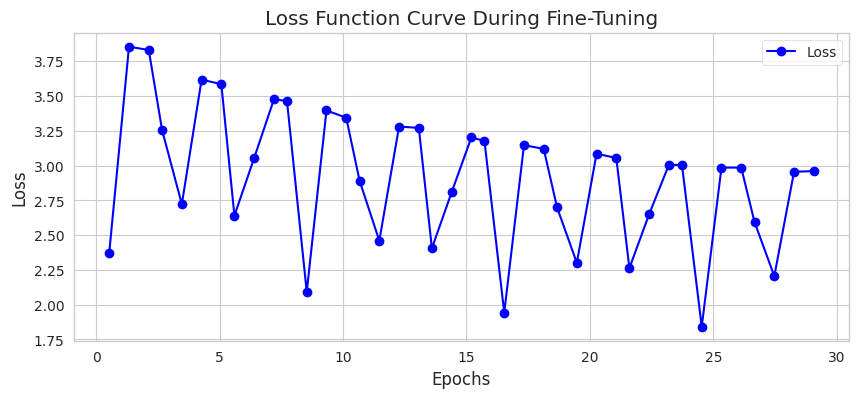

In [54]:
import matplotlib.pyplot as plt

# Loss values from the log
loss_values = [2.3753, 3.8554, 3.8321, 3.256, 2.7227, 3.6186, 3.5863, 2.6403, 
               3.0548, 3.477, 3.4649, 2.0916, 3.3973, 3.3444, 2.892, 2.4596, 
               3.2814, 3.2713, 2.4055, 2.8091, 3.2033, 3.1773, 1.9417, 3.1479, 
               3.1202, 2.6994, 2.301, 3.0855, 3.0556, 2.2627, 2.6508, 3.0061, 
               3.0049, 1.8415, 2.986, 2.9858, 2.5937, 2.2053, 2.9561, 2.9608]

# Epochs corresponding to the loss values
epochs = [0.53, 1.33, 2.13, 2.67, 3.47, 4.27, 5.07, 5.6, 6.4, 7.2, 7.73, 
          8.53, 9.33, 10.13, 10.67, 11.47, 12.27, 13.07, 13.6, 14.4, 15.2, 
          15.73, 16.53, 17.33, 18.13, 18.67, 19.47, 20.27, 21.07, 21.6, 22.4, 
          23.2, 23.73, 24.53, 25.33, 26.13, 26.67, 27.47, 28.27, 29.07]

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_values, marker='o', color='b', linestyle='-', label='Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function Curve During Fine-Tuning')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


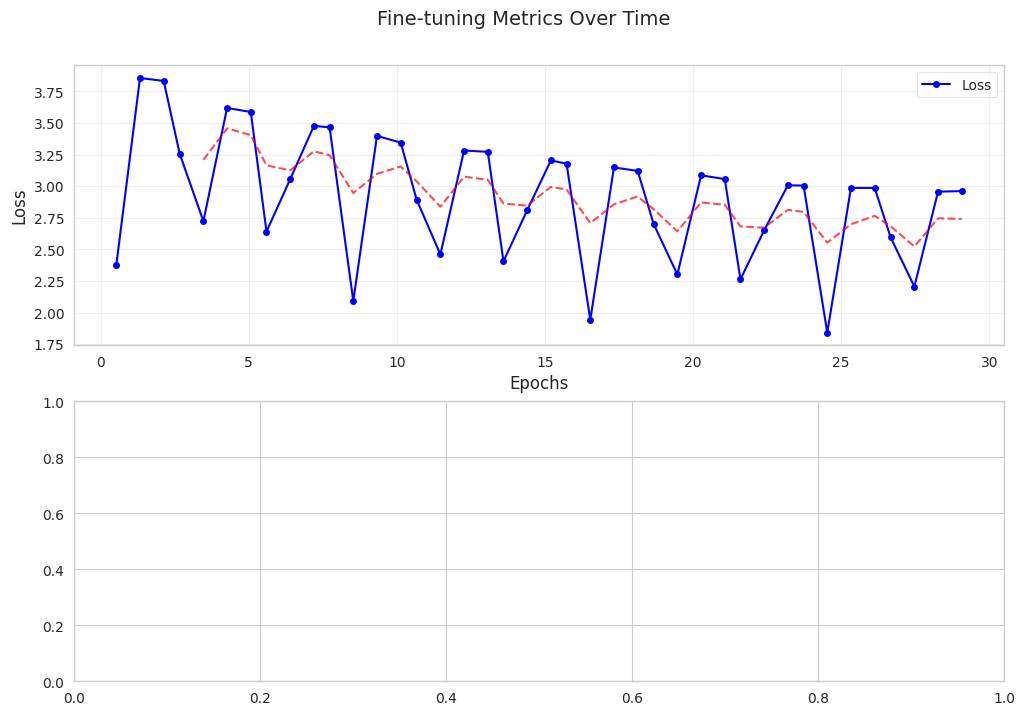

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
epochs = [0.53, 1.33, 2.13, 2.67, 3.47, 4.27, 5.07, 5.6, 6.4, 7.2, 7.73, 
          8.53, 9.33, 10.13, 10.67, 11.47, 12.27, 13.07, 13.6, 14.4, 15.2, 
          15.73, 16.53, 17.33, 18.13, 18.67, 19.47, 20.27, 21.07, 21.6, 22.4, 
          23.2, 23.73, 24.53, 25.33, 26.13, 26.67, 27.47, 28.27, 29.07]

losses = [2.3753, 3.8554, 3.8321, 3.256, 2.7227, 3.6186, 3.5863, 2.6403, 
          3.0548, 3.477, 3.4649, 2.0916, 3.3973, 3.3444, 2.892, 2.4596, 
          3.2814, 3.2713, 2.4055, 2.8091, 3.2033, 3.1773, 1.9417, 3.1479, 
          3.1202, 2.6994, 2.301, 3.0855, 3.0556, 2.2627, 2.6508, 3.0061, 
          3.0049, 1.8415, 2.986, 2.9858, 2.5937, 2.2053, 2.9561, 2.9608]

learning_rates = [3e-5, 6e-5, 9e-5, 1.2e-4, 1.5e-4, 1.8e-4, 2.1e-4, 2.4e-4, 
                  2.7e-4, 3e-4, 2.9e-4, 2.8e-4, 2.7e-4, 2.6e-4, 2.5e-4, 2.4e-4, 
                  2.3e-4, 2.2e-4, 2.1e-4, 2e-4, 1.9e-4, 1.8e-4, 1.7e-4, 1.6e-4, 
                  1.5e-4, 1.4e-4, 1.3e-4, 1.2e-4, 1.1e-4, 1e-4, 9e-5, 8e-5, 
                  7e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5, 0]

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Fine-tuning Metrics Over Time', fontsize=14, y=0.95)

# Plot 1: Loss
ax1.plot(epochs, losses, 'b-o', markersize=4, label='Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Calculate moving average for smoother visualization
window_size = 5
moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
ax1.plot(epochs[window_size-1:], moving_avg, 'r--', label='Moving Average (window=5)', alpha=0.7)

